## Import Libraries

In [1]:
!pip install pytorch_lightning
!pip install wandb
import torch
torch.cuda.empty_cache()
import torch.utils.data as data
import zipfile
import wandb
import warnings
warnings.filterwarnings("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Preprocessing

###Mounting Drive




In [2]:
# # Mount Google Drive to access the dataset
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # Set the path to your zipped dataset
# zip_file_path = '/content/drive/MyDrive/DL /aksharantar_sampled.zip'

# # Extract the dataset to a folder in Google Drive
# zip_ref = zipfile.ZipFile(zip_file_path, 'r')
# zip_ref.extractall('aksharantar_sampled_extracted')
# zip_ref.close()

In [4]:
# from matplotlib.font_manager import FontProperties
# import seaborn as sns
# # !unzip Tiro_Devanagari_Hindi.zip -d hindi
# # hindi_font = FontProperties(fname = '/kaggle/input/tiro-devanagari-hindi/TiroDevanagariHindi-Regular.ttf')


In [5]:
import torch
import torch.nn as nn
# from google.colab import drive
import csv
# move tensors to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Path to your CSV file on Google Drive (Extracted file)
csv_file_path = '/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_train.csv'

# Read the CSV file and extract the sequence of characters
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    chars = []
    for row in reader:
        chars.extend(row[0])  # assuming the first column of the CSV file contains the text data

charS=set(chars)
charS.add('|')
char_set = list(charS)

# Define the mapping between characters and integer indices
char_to_idx_latin= {char: i+1 for i, char in enumerate(char_set)}


In [6]:
max_length_devanagari=0
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    chars = []

    for row in reader:
        chars.extend(row[1])  # assuming the first column of the CSV file contains the text data

# Define the character set
charS=set(chars)
charS.add('|')
char_set = list(charS)

# Define the mapping between characters and integer indices
char_to_idx_lang ={char: i+1 for i, char in enumerate(char_set)}

In [7]:
max_length_latin = 0

# Read the CSV file and extract the sequence of characters
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    chars = []

    for row in reader:
        length = len(row[0])  # assuming the column you want to check is the first one
        if length > max_length_latin:
            max_length_latin = length

In [8]:
max_length_devanagari = 0
# Read the CSV file and extract the sequence of characters
with open(csv_file_path, 'r') as f:
    reader = csv.reader(f)
    chars = []

    for row in reader:
        length = len(row[1])  # assuming the column you want to check is the first one
        if length > max_length_devanagari:
            max_length_devanagari = length

Converting characters in words to indices












In [9]:
def word_to_indices(word, max_length,dict):
    # Convert the characters to integer indices using the char_to_idx mapping
    indices = [dict.get(c, -1) for c in word]
    # Filter out characters not in the dictionary
    indices = [idx for idx in indices if idx >= 0]
    # Add padding if necessary to make the sequence length equal to max_length
    if len(indices) < max_length:
        indices += [0] * (max_length - len(indices))
    # Truncate the sequence if necessary to make the sequence length equal to max_length
    elif len(indices) > max_length:
        indices = indices[:max_length]
    # Add the start and end tokens to the sequence
    indices = [dict['|']] + indices + [dict['|']]
    # Convert the list of indices to a tensor
    tensor = torch.tensor(indices)
    tensor=tensor.to(device)
    return tensor

pairs=[]
# Read the CSV file containing Latin-Devanagari word pairs
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_train.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        latin_word = row[0]
        devanagari_word = row[1]
        # Convert the Latin word to a tensor of integer indices
        latin_indices = word_to_indices(latin_word, max_length_latin,char_to_idx_latin)
        devanagari_indices= word_to_indices(devanagari_word,max_length_devanagari ,char_to_idx_lang)
        pairs.append([latin_indices,devanagari_indices])

pairs_v=[]
# Read the CSV file containing Latin-Devanagari word pairs
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_valid.csv', 'r') as f_v:
    reader_v = csv.reader(f_v)
    for row in reader_v:
        latin_word = row[0]
        devanagari_word = row[1]
        # Convert the Latin word to a tensor of integer indices
        latin_indices = word_to_indices(latin_word, max_length_latin,char_to_idx_latin)
        devanagari_indices= word_to_indices(devanagari_word,max_length_devanagari ,char_to_idx_lang)
        pairs_v.append([latin_indices,devanagari_indices])

pairs_t=[]
# Read the CSV file containing Latin-Devanagari word pairs
with open('/kaggle/input/aksharantar-sampled/aksharantar_sampled/hin/hin_test.csv', 'r') as f_t:
    reader_t = csv.reader(f_t)
    for row in reader_t:
        latin_word = row[0]
        devanagari_word = row[1]
        # Convert the Latin word to a tensor of integer indices
        latin_indices = word_to_indices(latin_word, max_length_latin,char_to_idx_latin)
        devanagari_indices= word_to_indices(devanagari_word,max_length_devanagari ,char_to_idx_lang)
        pairs_t.append([latin_indices,devanagari_indices])

Loading Data

In [10]:
train_dataloader = torch.utils.data.DataLoader(pairs, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(pairs_v, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(pairs_t, batch_size=64, shuffle=False)

### Sweep Configuration

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs23m032. Use `wandb login --relogin` to force relogin


Model Without Attention

In [12]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_size,cell_type,drop_out,num_layers,bidirectional):
        '''Initialize the Encoder class.
              
        Args:
            input_dim (int): Dimensionality of the input sequence.
            hidden_dim (int): Dimensionality of the hidden state in the encoder.
            embedding_size (int): Size of the input embedding.
            cell_type (str): Type of the RNN cell to use (e.g., LSTM, GRU).
            drop_out (float): Dropout probability to apply to the RNN output.
            num_layers (int): Number of layers in the encoder.
            bidirectional (bool): Flag indicating if the encoder is bidirectional.

        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_dim, embedding_size)

        if(cell_type=="GRU"):
          self.rnn = nn.GRU(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cell_type=="LSTM"):
          self.rnn = nn.LSTM(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cell_type=="RNN"): 
          self.rnn = nn.RNN(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

    def forward(self, x):
        '''Perform forward pass in the Encoder.
        
        Encode the input sequence into a fixed-size representation.
        
        Args:
            x (Tensor): Input tensor of shape (sequence_length, batch_size).

        Returns:
            Tensor: Encoded representation of the input sequence.

        '''
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        return hidden

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim,embedding_size ,cell_type,drop_out,num_layers,bidirectional):
        '''Initialize the Decoder class.
                
        Args:
            output_dim (int): Dimensionality of the output sequence.
            hidden_dim (int): Dimensionality of the hidden state in the decoder.
            embedding_size (int): Size of the input embedding.
            cell_type (str): Type of the RNN cell to use (e.g., LSTM, GRU).
            drop_out (float): Dropout probability to apply to the RNN output.
            num_layers (int): Number of layers in the decoder.
            bidirectional (bool): Flag indicating if the decoder is bidirectional.

        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(output_dim, embedding_size)
        self.bidirectional = bidirectional
        self.cell_type=cell_type
        D=1
        if self.bidirectional:
          D=2

        if(cell_type=="GRU"):
          self.rnn = nn.GRU(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers ,bidirectional=bidirectional)
        elif(cell_type=="LSTM"):
          self.rnn = nn.LSTM(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        elif(cell_type=="RNN"):
          self.rnn = nn.RNN(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim*D, output_dim)

    def forward(self, x, hidden):
        '''Perform forward pass in the Decoder.
        
        Generate the output sequence by decoding the encoded representation.
        
        Args:
            x (Tensor): Input tensor of shape (sequence_length, batch_size).
            hidden (Tensor): Initial hidden state of the decoder.

        Returns:
            Tensor: Output tensor of shape (sequence_length, batch_size, output_dim).
            Tensor: Updated hidden state of the decoder.

        '''
        x = x.unsqueeze(0)
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        prediction = self.fc(output.squeeze(0))
        return prediction, hidden

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F

class Seq2Seq(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden_dim,embedding_size, cell_type, drop_out,num_layers_encoders,num_layers_decoders,bidirectional,learning_rate):
        '''Initialize the Seq2Seq model.
        
        Define the architecture and parameters of the sequence-to-sequence model.
        
        Args:
            input_dim (int): Dimensionality of the input sequence.
            output_dim (int): Dimensionality of the output sequence.
            hidden_dim (int): Dimensionality of the hidden state in the encoder and decoder.
            embedding_size (int): Size of the input embedding.
            cell_type (str): Type of the RNN cell to use (e.g., LSTM, GRU).
            drop_out (float): Dropout probability to apply to the RNN output.
            num_layers_encoders (int): Number of layers in the encoder.
            num_layers_decoders (int): Number of layers in the decoder.
            bidirectional (bool): Flag indicating if the encoder and decoder are bidirectional.
            learning_rate (float): Learning rate for the optimizer.

        '''
        super().__init__()

        self.val_loss=[]
        self.test_loss=[]
        self.train_loss=[]

        self.train_accuracy=[]
        self.val_accuracy=[]
        self.test_accuracy=[]

        self.encoder = Encoder(input_dim, hidden_dim, embedding_size,cell_type,drop_out,num_layers_encoders,bidirectional)
        self.decoder = Decoder(output_dim, hidden_dim, embedding_size, cell_type,drop_out,num_layers_decoders,bidirectional)
        self.num_layers_encoders=num_layers_encoders
        self.num_layers_decoders=num_layers_decoders

        self.learning_rate=learning_rate
        self.cell_type=cell_type

        self.bidirectional = bidirectional
        self.D=1
        if self.bidirectional:
          self.D=2

    def forward(self, src, trg,teacher_forcing_ratio=0.5):
        '''Perform forward pass in the Seq2Seq model.

        Encode the source sequence, then decode it to generate the target sequence.
        
        Args:
            src (Tensor): Source input tensor of shape (source_sequence_length, batch_size).
            trg (Tensor): Target input tensor of shape (target_sequence_length, batch_size).
            teacher_forcing_ratio (float): Probability of using teacher forcing during decoding.

        Returns:
            Tensor: Output tensor of shape (target_sequence_length, batch_size, output_dim).

        '''
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        src = src.transpose(0,1)
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        hidden = self.encoder(src)

        if(self.num_layers_encoders>self.num_layers_decoders):
          if(self.cell_type=="LSTM"):
            (hidden,cell)=hidden
            difference=self.num_layers_encoders*self.D-self.num_layers_decoders*self.D
            hidden=hidden[difference:]
            cell=cell[difference:]
            #from the difference to the last
            hidden=(hidden,cell)

          else:  
            difference=self.num_layers_encoders*self.D-self.num_layers_decoders*self.D
            hidden=hidden[difference:]  #from the difference to the last

        elif(self.num_layers_encoders<self.num_layers_decoders):
          cell=[]
          if(self.cell_type=="LSTM"):
            (hidden,cell)=hidden
            
            last_hidden = hidden[-self.D:]  # Shape: [1, 64, 256]
            last_cell = cell[-self.D:]
            for i in range(self.num_layers_encoders,self.num_layers_decoders):
              hidden = torch.cat([hidden, last_hidden], dim=0)  # Shape: [4, 64, 256]
              cell = torch.cat([cell, last_cell], dim=0)  # Shape: [4, 64, 256]
            hidden=(hidden,cell)

          else:

            last_hidden = hidden[-self.D:] # Shape: [1, 64, 256]

            for i in range(self.num_layers_encoders,self.num_layers_decoders):
              hidden = torch.cat([hidden, last_hidden], dim=0)  # Shape: [4, 64, 256]

        input = trg[:,0]#start character
        for t in range(1, max_len):
            output, hidden = self.decoder(input, hidden)
            outputs[t] = output
            top1 = output.argmax(1)
            input = top1 if teacher_forcing_ratio < torch.rand(1).item() else trg[:,t]
            #if teacher_forcing_ratio > the random number generated then use the predicted character at the timestep t in timestamp t+1, else use the true value from the target 
        return outputs

    def training_step(self, batch, batch_idx):
        '''Perform a single training step.
        
        Compute the loss, update the model's parameters, and return the loss value.
        
        Args:
            batch (tuple): Batch of input and target sequences.
            batch_idx (int): Index of the current batch.

        Returns:
            Tensor: Loss value.

        '''

        src, trg = batch
        # Forward pass through the model
        output = self(src, trg)
        outputAcc = self(src, trg)
        trgAcc=trg 

        outputAcc = outputAcc.permute(1, 0, 2)
        cols = torch.arange(output.shape[1]).unsqueeze(1)        
        rows = torch.arange(output.shape[0])
        # Create a tensor of zeros for expected values and assign 1 at corresponding positions
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        # Get the output and expected values in the appropriate shape for loss calculation
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        train_loss = self.loss_fn(output.to(device), expected.to(device))

        train_accuracy =self.accuracy(outputAcc, trgAcc)    #trg is the true value
        self.train_accuracy.append(torch.tensor(train_accuracy))
        self.train_loss.append(torch.tensor(train_loss))

        return {'loss': train_loss}

    def validation_step(self, batch, batch_idx):
        '''Perform a single validation step.
        
        Evaluate the model's performance on a validation batch and return the results.
        
        Args:
            batch (tuple): Batch of input and target sequences.
            batch_idx (int): Index of the current batch.

        '''


        src, trg = batch
        # Forward pass through the model with a flag value of 0

        output = self(src, trg,0)
        outputAcc = self(src, trg,0)
        trgAcc=trg
        # Permute the dimensions of outputAcc for further processing
        outputAcc = outputAcc.permute(1, 0, 2)

        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])
        # Create a tensor of zeros for expected values and assign 1 at corresponding positions
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        # Get the output and expected values in the appropriate shape for loss calculation
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        val_loss = self.loss_fn(output.to(device), expected.to(device))

        val_accuracy =self.accuracy(outputAcc, trgAcc)   
        self.val_accuracy.append(torch.tensor(val_accuracy))
        self.val_loss.append(torch.tensor(val_loss))
        return {'loss': val_loss}

    def test_step(self, batch, batch_idx):
        '''Perform a single test step.
        
        Evaluate the model's performance on a test batch and return the results.
        
        Args:
            batch (tuple): Batch of input and target sequences.
            batch_idx (int): Index of the current batch.

        '''
        src, trg = batch
        # Get the output and expected values for evaluation
        output = self(src, trg,0)
        outputAcc = self(src, trg,0)
        trgAcc=trg

        outputAcc = outputAcc.permute(1, 0, 2)
        # Create indices for indexing the expected tensor
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])
        # Create a tensor of zeros with the same size as output for expected values
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        # Reshape the output and expected tensors for loss calculation
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        test_loss = self.loss_fn(output.to(device), expected.to(device))
        test_accuracy =self.accuracy(outputAcc, trgAcc)    #trg is the true value
        grid_input,grid_target,grid_predicted=self.grid(src,outputAcc, trgAcc)

        # Convert grid target and predicted values to string representations
        target_outputs=[]
        str_target=""
        for i in grid_target:
          for j in i:
            integer_value = j.item()
            str_target=str_target+get_key(j)
          target_outputs.append(str_target)
          str_target=""

        predicted_outputs=[]
        str_predicted=""
        for i in grid_predicted:
          for j in i:
            integer_value = j.item()
            str_predicted=str_predicted+get_key(j)
          predicted_outputs.append(str_predicted)
          str_predicted=""

        inputs=[]
        str_input=""
        for i in grid_input:
          for j in i:
            integer_value = j.item()
            str_input=str_input+get_key_input(j)
          inputs.append(str_input)
          str_input=""

        # Append test accuracy and loss to their respective lists
        self.test_accuracy.append(torch.tensor(test_accuracy))
        self.test_loss.append(torch.tensor(test_loss))
#         print({"test_loss":test_loss,"test_accuracy":test_accuracy})
        wandb.log({"test_loss":test_loss,"test_accuracy":test_accuracy})

        save_outputs_to_csv(inputs,target_outputs, predicted_outputs)
        return {'loss':test_loss}


    def configure_optimizers(self):
        """
        Configure the optimizer.
        """
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate )
        return optimizer

    def loss_fn(self, output, trg):
        """
        Calculate the loss function.
        """
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, trg)
        return loss.mean()

    def accuracy(self, output, target):
      """
      Calculate the accuracy.
      """
      predicted = output.argmax(dim=-1)  # shape: (sequence_length, batch_size)
      equal_rows = 0
      for i in range(target.size(0)):
          # Remove the first and last indices and check if the sliced tensors are equal
          if torch.all(torch.eq(target[i, 1:-1], predicted[i, 1:-1])):
              equal_rows += 1
      matches=equal_rows

      # Compute the accuracy
      accuracy = matches / len(target) * 100
      return accuracy

    # def grid(self, output, target):
    #   """
    #   Generate grids for target and expected outputs.
    #   """
    #   grid_target=[]
    #   grid_expected=[]
    #   predicted = output.argmax(dim=-1)  # shape: (sequence_length, batch_size)
    #   for i in range(target.size(0)):
    #       # Remove the first and last indices and check if the sliced tensors are equal
    #       grid_target.append(target[i, 1:-1])
    #       grid_expected.append(predicted[i, 1:-1])

    #   return grid_target,grid_expected

    def grid(self,input, output, target):
      """
      Generate grids for target and expected outputs.
      """
      grid_input=[]
      grid_target=[]
      grid_expected=[]
      predicted = output.argmax(dim=-1) 
      for i in range(target.size(0)):
          # Remove the first and last indices and check if the sliced tensors are equal
          grid_target.append(target[i, 1:-1])
          grid_expected.append(predicted[i, 1:-1])
          grid_input.append(input[i, 1:-1])
      return grid_input,grid_target,grid_expected


    def on_train_epoch_end(self):
      """
      Actions to perform at the end of each training epoch.
      """
      train_loss=torch.stack(self.train_loss).mean()
      self.train_loss=[]

      val_loss=torch.stack(self.val_loss).mean()
      self.val_loss=[]

      train_accuracy=torch.stack(self.train_accuracy).mean()
      self.train_accuracy=[]

      val_accuracy=torch.stack(self.val_accuracy).mean()
      self.val_accuracy=[]
#       print({"train_loss":train_loss,"train_accuracy":train_accuracy,"val_loss":val_loss,"val_accuracy":val_accuracy})
      wandb.log({"train_loss":train_loss,"train_accuracy":train_accuracy,"val_loss":val_loss,"val_accuracy":val_accuracy})

# function to return key for any value 
def get_key(val):
    for key, value in char_to_idx_lang.items():
        if val == value:
            return key
    return ""

def get_key_input(val):
    for key, value in char_to_idx_latin.items():
        if val == value:
            return key
    return ""

def beam_search(self, encoder_output, encoder_hidden, decoder_input, beam_width,batch_size,max_len,trg_vocab_size,output):
    # Set initial beam
    beam = [(decoder_input, 0, encoder_hidden)]
    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)


    # Iterate through the sequence
    for i in range(self.max_seq_len):
        new_beam = []
        for j in range(len(beam)):
            decoder_input = beam[j][0]
            decoder_hidden = beam[j][2]

            # Run the decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_output)

            # Get the top-k most probable tokens
            topk_probs, topk_indices = torch.topk(decoder_output, beam_width)

            for k in range(beam_width):
                # Calculate the new score
                score = beam[j][1] + topk_probs[0][k]

                # Create a new hypothesis
                hypothesis = (
                    torch.tensor([topk_indices[0][k]]).to(self.device),
                    score,
                    decoder_hidden
                )

                # Add it to the new beam
                new_beam.append(hypothesis)
        outputs[t] = output

        # Select the top-k hypotheses
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

    return 

# importing pandas as pd  
import pandas as pd  
import os

def save_outputs_to_csv(inputs,target_outputs, predicted_outputs):
    file_exists = os.path.exists('Output.csv')
    # dictionary of lists  
    dict = {'input':inputs,'target':target_outputs, 'predicted': predicted_outputs}  
    df = pd.DataFrame(dict) 
    # saving the dataframe 
    df.to_csv('Output.csv',mode='a',index=False,header=not file_exists) 

Model With Attention


In [13]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class AttnEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_size,cell_type,drop_out,num_layers,bidirectional):

        """
        Initializes the Attention Encoder module.

        Args:
            input_dim (int): Dimensionality of the input.
            hidden_dim (int): Dimensionality of the hidden state/output.
            embedding_size (int): Size of the embedding for input sequence.
            cell_type (str): Type of RNN cell to use (GRU, LSTM, RNN).
            drop_out (float): Dropout rate.
            num_layers (int): Number of layers in the RNN.
            bidirectional (bool): Flag indicating whether to use bidirectional RNN.

        """
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional
        self.embedding = nn.Embedding(input_dim, embedding_size)

        if(cell_type=="GRU"):
          self.rnn = nn.GRU(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cell_type=="LSTM"):
          self.rnn = nn.LSTM(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        if(cell_type=="RNN"): 
          self.rnn = nn.RNN(embedding_size, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

    def forward(self, x):
        """
        Performs a forward pass of the Attention Encoder module.

        Args:
            x (tensor): Input tensor of shape (seq_len, batch_size).

        Returns:
            output (tensor): Output tensor from the RNN layer.
            hidden (tensor): Hidden state from the RNN layer.

        """
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        return output, hidden

class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim,embedding_size ,cell_type,drop_out,num_layers,bidirectional,max_length):
        """
        Initializes the Attention Decoder module.

        Args:
            output_dim (int): Dimensionality of the output.
            hidden_dim (int): Dimensionality of the hidden state/output.
            embedding_size (int): Size of the embedding for output sequence.
            cell_type (str): Type of RNN cell to use (GRU, LSTM, RNN).
            drop_out (float): Dropout rate.
            num_layers (int): Number of layers in the RNN.
            bidirectional (bool): Flag indicating whether to use bidirectional RNN.
            max_length (int): Maximum length of the input sequence.

        """

        self.max_length=max_length+2
        super(AttnDecoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(output_dim, embedding_size)
        self.attn = nn.Linear(self.hidden_dim + embedding_size, self.max_length)
        self.bidirectional = bidirectional
        self.cell_type=cell_type
        D=1
        if self.bidirectional:
          D=2
        self.attn_combine = nn.Linear(self.hidden_dim*D + embedding_size, self.hidden_dim)

        if(cell_type=="GRU"):
          self.rnn = nn.GRU(hidden_dim, hidden_dim,dropout=drop_out,num_layers=num_layers ,bidirectional=bidirectional)
        elif(cell_type=="LSTM"):
          self.rnn = nn.LSTM(hidden_dim, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)
        elif(cell_type=="RNN"):
          self.rnn = nn.RNN(hidden_dim, hidden_dim,dropout=drop_out,num_layers=num_layers,bidirectional=bidirectional)

        self.fc = nn.Linear(hidden_dim*D, output_dim)

    def forward(self, x, hidden, encoder_outputs):
        """
        Performs a forward pass of the Attention Decoder module.

        Args:
            x (tensor): Input tensor of shape (batch_size).
            hidden (tensor): Hidden state from the previous time step.
            encoder_outputs (tensor): Encoder outputs of shape (seq_len, batch_size, hidden_dim).

        Returns:
            prediction (tensor): Output tensor from the linear layer.
            hidden (tensor): Hidden state for the current time step.
            attn_weights (tensor): Attention weights for the current time step.

        """
        x = x.unsqueeze(1).transpose(0,1)
        embedded = self.embedding(x)
        # Calculate attention weights based on the cell type
        if(self.cell_type=="LSTM"):
          attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        else:
          attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        # Calculate the attention applied to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(1),
                                 encoder_outputs.permute(1,0,2))
        # Concatenate embedded input and attention applied tensor
        output = torch.cat((embedded[0], attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        # Adjust hidden and cell variables based on the cell type
        if(self.cell_type=="LSTM"):
          (hidden,cell)=hidden

        if(self.cell_type=="LSTM"):
          output, hidden = self.rnn(output, (hidden,cell))
        else:
          output, hidden = self.rnn(output, hidden)

        prediction = self.fc(output.squeeze(0))
        # Return prediction, hidden state, and attention weights
        return prediction, hidden, attn_weights

import torch.nn.functional as F

class Seq2SeqAttn(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden_dim,embedding_size, cell_type, drop_out,num_layers_encoders,num_layers_decoders,bidirectional,learning_rate,max_length_latin):
        """
        Initializes the Seq2Seq model.

        Args:
            input_dim (int): Dimensionality of the input sequence.
            output_dim (int): Dimensionality of the output sequence.
            hidden_dim (int): Dimensionality of the hidden state/output.
            embedding_size (int): Size of the embedding for input/output sequences.
            cell_type (str): Type of RNN cell to use (GRU, LSTM, RNN).
            drop_out (float): Dropout rate.
            num_layers (int): Number of layers in the RNN.
            bidirectional (bool): Flag indicating whether to use bidirectional RNN.
            max_length (int): Maximum length of the input sequence.

        """
        super().__init__()

        self.val_loss=[]
        self.train_loss=[]

        self.train_accuracy=[]
        self.val_accuracy=[]

        self.test_accuracy=[]
        self.test_loss=[]

        self.encoder = AttnEncoder(input_dim, hidden_dim, embedding_size,cell_type,drop_out,num_layers_encoders,bidirectional)
        self.decoder = AttnDecoder(output_dim, hidden_dim, embedding_size, cell_type,drop_out,num_layers_decoders,bidirectional,max_length_latin)

        self.num_layers_encoders=num_layers_encoders
        self.num_layers_decoders=num_layers_decoders

        self.learning_rate=learning_rate
        self.cell_type=cell_type

        self.bidirectional = bidirectional
        self.D=1
        if self.bidirectional:
          self.D=2
        self.attn_weights=[]
        self.counter=0


    def forward(self, src, trg,teacher_forcing_ratio=0.5):
        """
        Performs a forward pass of the Seq2Seq model.

        Args:
            source (tensor): Input tensor of shape (seq_len, batch_size).
            target (tensor): Target tensor of shape (seq_len, batch_size).
            teacher_forcing_ratio (float): The probability of using teacher forcing.

        Returns:
            outputs (tensor): Output tensor from the decoder of shape (seq_len, batch_size, output_dim).

        """
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features
        # Transpose the source tensor
        src = src.transpose(0,1)
        # Initialize outputs tensor with zeros
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        attentionV = torch.zeros(max_len, batch_size, max_length_latin+2).to(self.device)

        encoder_output,hidden = self.encoder(src)

        input = trg[:,0] #start character
        # Iterate over each timestep in the target sequence
        for t in range(1, max_len):
            # Pass the input, hidden state, and encoder output to the decoder

            output, hidden,attentionV[t] = self.decoder(input, hidden,encoder_output)
            outputs[t] = output
            # Determine the next input based on teacher forcing ratio
            top1 = output.argmax(1)
            
            input = top1 if teacher_forcing_ratio < torch.rand(1).item() else trg[:,t]
            #if teacher_forcing_ratio > the random number generated then use the predicted character at the timestep t in timestamp t+1, else use the true value from the target 

        return outputs, attentionV

    def training_step(self, batch, batch_idx):
        """
        Trains the Seq2Seq model.

        Args:
            model (nn.Module): The Seq2Seq model to train.
            iterator (DataLoader): The data iterator.
            optimizer (torch.optim.Optimizer): The optimizer to use for training.
            criterion (nn.Module): The loss function.
            clip (float): The value to clip the gradients.

        Returns:
            epoch_loss (float): The average loss for the epoch.

        """
        # Get the source and target tensors from the batch
        src, trg = batch
        output, attentionV = self(src, trg)
        outputAcc, attentionVD = self(src, trg)
        trgAcc=trg 
        # Permute the output for accuracy calculation
        outputAcc = outputAcc.permute(1, 0, 2)
        cols = torch.arange(output.shape[1]).unsqueeze(1)        
        rows = torch.arange(output.shape[0])
        # Create a tensor for expected values and assign 1 to the corresponding indices
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1

        output_dim = output.shape[-1]
        # Remove the start token from the output and reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        train_loss = self.loss_fn(output.to(device), expected.to(device))
        train_accuracy =self.accuracy(outputAcc, trgAcc)    #trg is the true value
        # Append the training accuracy and loss to their respective lists
        self.train_accuracy.append(torch.tensor(train_accuracy))
        self.train_loss.append(torch.tensor(train_loss))
        # del src
        # del trg
        return {'loss': train_loss}

    def validation_step(self, batch, batch_idx):
        """
        Perform a validation step.
        """
        src, trg = batch
        output,attentionV = self(src, trg,0)
        outputAcc,attentionV = self(src, trg,0)
        trgAcc=trg
        # Permute the output for accuracy calculation
        outputAcc = outputAcc.permute(1, 0, 2)
        # Create indices for expected values
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        output_dim = output.shape[-1]
        # Remove the start token from the output and reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        val_loss = self.loss_fn(output.to(device), expected.to(device))
        val_accuracy =self.accuracy(outputAcc, trgAcc)    #trg is the true value
        # Append the training accuracy and loss to their respective lists
        self.val_accuracy.append(torch.tensor(val_accuracy))
        self.val_loss.append(torch.tensor(val_loss))
        return {'loss': val_loss}


    def configure_optimizers(self):
        """
        Configure the optimizer.
        """
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate )
        return optimizer

    def loss_fn(self, output, trg):
        """
        Calculate the loss function.
        """
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, trg)
        return loss.mean()

    def accuracy(self, output, target):
      """
      Calculate the loss function.
      """
      predicted = output.argmax(dim=-1)  # shape: (sequence_length, batch_size)
      equal_rows = 0
      for i in range(target.size(0)):
          # Remove the first and last indices and check if the sliced tensors are equal
          if torch.all(torch.eq(target[i, 1:-1], predicted[i, 1:-1])):
              equal_rows += 1
      matches=equal_rows

      # Compute the accuracy
      accuracy = matches / len(target) * 100
      return accuracy

    def grid(self,input, output, target):
      """
      Generate grids for target and expected outputs.
      """
      grid_input=[]
      grid_target=[]
      grid_expected=[]
      predicted = output.argmax(dim=-1) 
      for i in range(target.size(0)):
          # Remove the first and last indices and check if the sliced tensors are equal
          grid_target.append(target[i, 1:-1])
          grid_expected.append(predicted[i, 1:-1])
          grid_input.append(input[i, 1:-1])
      return grid_input,grid_target,grid_expected


    def on_train_epoch_end(self):
      """
      Actions to perform at the end of each training epoch.
      """
      train_loss=torch.stack(self.train_loss).mean()
      self.train_loss=[]

      val_loss=torch.stack(self.val_loss).mean()
      self.val_loss=[]

      train_accuracy=torch.stack(self.train_accuracy).mean()
      self.train_accuracy=[]

      val_accuracy=torch.stack(self.val_accuracy).mean()
      self.val_accuracy=[]
#       print({"train_loss":train_loss,"train_accuracy":train_accuracy,"val_loss":val_loss,"val_accuracy":val_accuracy})
      wandb.log({"train_loss":train_loss,"train_accuracy":train_accuracy,"val_loss":val_loss,"val_accuracy":val_accuracy})


    def test_step(self, batch, batch_idx):
        """
        Perform a test step.
        """
        src, trg = batch
        output, attentionV = self(src, trg,0)
        outputAcc, attentionVD = self(src, trg,0)
        trgAcc=trg
        # Permute the output for accuracy calculation
        outputAcc = outputAcc.permute(1, 0, 2)
        cols = torch.arange(output.shape[1]).unsqueeze(1)
        rows = torch.arange(output.shape[0])
        # Create a tensor for expected values and assign 1 to the corresponding indices
        expected = torch.zeros(size=output.shape)
        expected[rows, cols, trg.cpu()] = 1
        output_dim = output.shape[-1]
        # Remove the start token from the output and reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        expected = expected[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)

        test_loss = self.loss_fn(output.to(device), expected.to(device))
        test_accuracy =self.accuracy(outputAcc, trgAcc)    #trg is the true value
        grid_input,grid_target,grid_predicted=self.grid(src,outputAcc, trgAcc)

        # Convert grid-based outputs to string representations
        target_outputs=[]
        str_target=""
        for i in grid_target:
          for j in i:
            integer_value = j.item()
            str_target=str_target+get_key(j)
          target_outputs.append(str_target)
          str_target=""
        predicted_outputs=[]
        str_predicted=""
        for i in grid_predicted:
          for j in i:
            integer_value = j.item()
            str_predicted=str_predicted+get_keyAttn(j)
          predicted_outputs.append(str_predicted)
          str_predicted=""

        inputs=[]
        str_input=""
        for i in grid_input:
          for j in i:
            integer_value = j.item()
            str_input=str_input+get_key_input(j)
          inputs.append(str_input)
          str_input=""

        # Append test accuracy and loss to their respective lists
        self.test_accuracy.append(torch.tensor(test_accuracy))
        self.test_loss.append(torch.tensor(test_loss))
#         print({"test_loss":test_loss,"test_accuracy":test_accuracy})
        wandb.log({"test_loss":test_loss,"test_accuracy":test_accuracy})
        # Save target and predicted outputs to a CSV file
        save_outputs_to_csvAttn(inputs,target_outputs, predicted_outputs)
        # plot_attention_weights(self.attn_weights)
        if(self.counter<1):
          s(inputs,predicted_outputs,attentionV)
          self.counter=self.counter+1
        return {'loss':test_loss}

# function to return key for any value
def get_keyAttn(val):
    for key, value in char_to_idx_lang.items():
        if val == value:
            return key
    return ""
    
def get_key_inputAttn(val):
    for key, value in char_to_idx_latin.items():
        if val == value:
            return key
    return ""

def beam_searchAttn(self, encoder_output, encoder_hidden, decoder_input, beam_width,batch_size,max_len,trg_vocab_size,output):
    # Set initial beam
    beam = [(decoder_input, 0, encoder_hidden)]
    outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)

    # Iterate through the sequence
    for i in range(self.max_seq_len):
        new_beam = []
        for j in range(len(beam)):
            decoder_input = beam[j][0]
            decoder_hidden = beam[j][2]

            # Run the decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_output)

            # Get the top-k most probable tokens
            topk_probs, topk_indices = torch.topk(decoder_output, beam_width)

            for k in range(beam_width):
                # Calculate the new score
                score = beam[j][1] + topk_probs[0][k]

                # Create a new hypothesis
                hypothesis = (
                    torch.tensor([topk_indices[0][k]]).to(self.device),
                    score,
                    decoder_hidden
                )

                # Add it to the new beam
                new_beam.append(hypothesis)
        outputs[t] = output

        # Select the top-k hypotheses
        beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    return 

import pandas as pd  
      
def save_outputs_to_csvAttn(inputs,target_outputs, predicted_outputs):
    file_exists = os.path.exists('Output.csv')
    # dictionary of lists  
    dict = {'input':inputs,'target':target_outputs, 'predicted': predicted_outputs}  
    df = pd.DataFrame(dict) 
    # saving the dataframe 
    df.to_csv('Output.csv',mode='a',index=False,header=not file_exists) 


def s(input_words, output_words, attn_weights):
    # Create a figure with a 3x3 grid and set the size to 10x10 inches
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    
    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    # Iterate over each index up to 9 and plot the attention weights
    for i, ax in enumerate(axes.flat):
        # Check if input and output words are provided
        if i < len(input_words) and i < len(output_words):
            # Get the attention weights for the corresponding input word
            attn_weight = attn_weights[i].cpu().detach().numpy()
            attn_weight = attn_weight[1:len(input_words[i]) + 1, :len(output_words[i])]
            
            # Plot the attention weights as a heatmap on the current axis
            sns.heatmap(attn_weight, ax=ax, cmap='Blues', cbar=False)
            
            # Set the y-axis tick positions and labels to the input words and rotate them vertically
            ax.set_yticks(range(len(input_words[i])))
            ax.set_yticklabels(reversed(input_words[i]), rotation='vertical')
            
            # Set the x-axis tick positions and labels to the output words and rotate them horizontally
            ax.set_xticks(range(len(output_words[i])))
#             fontproperties=hindi_font,
            ax.set_xticklabels(reversed(output_words[i]), rotation=45, ha='right')
            
            # Set the title of each subplot as the index number
            ax.set_title(f'Attention {i+1}', fontsize=12)
        else:
            # If input or output words are missing, display a message in the subplot
            ax.text(0.5, 0.5, 'Missing Data', horizontalalignment='center', verticalalignment='center', fontsize=12)
            ax.axis('off')
        
    # Remove any unused subplots
    for j in range(len(input_words), len(axes.flat)):
        fig.delaxes(axes.flat[j])
    
    # Log the plot to Weights & Biases
    wandb.log({"Question 5": wandb.Image(plt)})
    
    plt.show()


### Running the wandb sweep

In [14]:
# def sweep():
#     '''Perform hyperparameter sweep using WandB.
    
#     Initialize the experiment configuration, create the model, train the model,
#     and log the results using WandB.

#     '''
#     wandb.init()
#     config = wandb.config

#     if(config.attention==False):
#       model = Seq2Seq(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, config.hidden_layer_size, config.input_embedding_size, config.cell_type,config.drop_out,config.number_of_encoder_layers,config.number_of_decoder_layers,config.bidirectional,config.learning_rate)

#     else:
#       model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, config.hidden_layer_size, config.input_embedding_size, config.cell_type,config.drop_out,1,1,config.bidirectional,config.learning_rate, max_length_latin)

#     model.to(device)
#     # Create a Trainer for training the model
#     trainer = pl.Trainer(max_epochs=config.epochs, accelerator="gpu", devices=1)
#     trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

#     # Generate a unique run name based on the hyperparameters
#     run_name = "lr_{}_hls_{}_es_{}_ct_{}_do_{}_bd_{}_lr_{}_att_{}".format(config.learning_rate, config.hidden_layer_size,config.input_embedding_size,config.cell_type, config.drop_out,config.bidirectional,config.learning_rate,config.attention)
#     print(run_name)
#     wandb.run.name = run_name

# # Initialize the WandB sweep
# # sweep_id = wandb.sweep(sweep_config,project=pName)
# # wandb.agent(sweep_id, sweep)

##Training and Evaluating the model with best hyperparameters

In [15]:
# hidden_layer_size=256
# embedding_size= 256
# cell_type="LSTM"
# drop_out=0.2
# num_layers_encoders=3
# num_layers_decoders=2
# bidirectional=True
# attention=False
# learning_rate=0.001
# epochs=15
# if(attention==False):
#   model = Seq2Seq(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,num_layers_encoders,num_layers_decoders,bidirectional,learning_rate)

# else:
#   model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,1,1,bidirectional,learning_rate, max_length_latin)

# model.to(device)

In [16]:
# hidden_layer_size=256
# embedding_size= 16
# cell_type="LSTM"
# drop_out=0.2
# num_layers_encoders=3
# num_layers_decoders=3
# bidirectional=True
# attention=True
# learning_rate=0.001
# epochs=10
# if(attention==False):
#   model = Seq2Seq(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,num_layers_encoders,num_layers_decoders,bidirectional,learning_rate)

# else:
#   model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,1,1,bidirectional,learning_rate, max_length_latin)

# model.to(device)

Seq2SeqAttn(
  (encoder): AttnEncoder(
    (embedding): Embedding(29, 16)
    (rnn): LSTM(16, 256, dropout=0.2, bidirectional=True)
  )
  (decoder): AttnDecoder(
    (embedding): Embedding(67, 16)
    (attn): Linear(in_features=272, out_features=26, bias=True)
    (attn_combine): Linear(in_features=528, out_features=256, bias=True)
    (rnn): LSTM(256, 256, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=512, out_features=67, bias=True)
  )
)

In [ ]:
hidden_layer_size=16
embedding_size= 16
cell_type="LSTM"
drop_out=0.2
num_layers_encoders=2
num_layers_decoders=2
bidirectional=True
attention=True
learning_rate=0.001
epochs=1
if(attention==False):
  model = Seq2Seq(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,num_layers_encoders,num_layers_decoders,bidirectional,learning_rate)

else:
  model = Seq2SeqAttn(len(char_to_idx_latin)+2, len(char_to_idx_lang)+2, hidden_layer_size, embedding_size, cell_type,drop_out,1,1,bidirectional,learning_rate, max_length_latin)

model.to(device)

2024-05-06 08:45:01.242541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:45:01.242646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:45:01.344962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

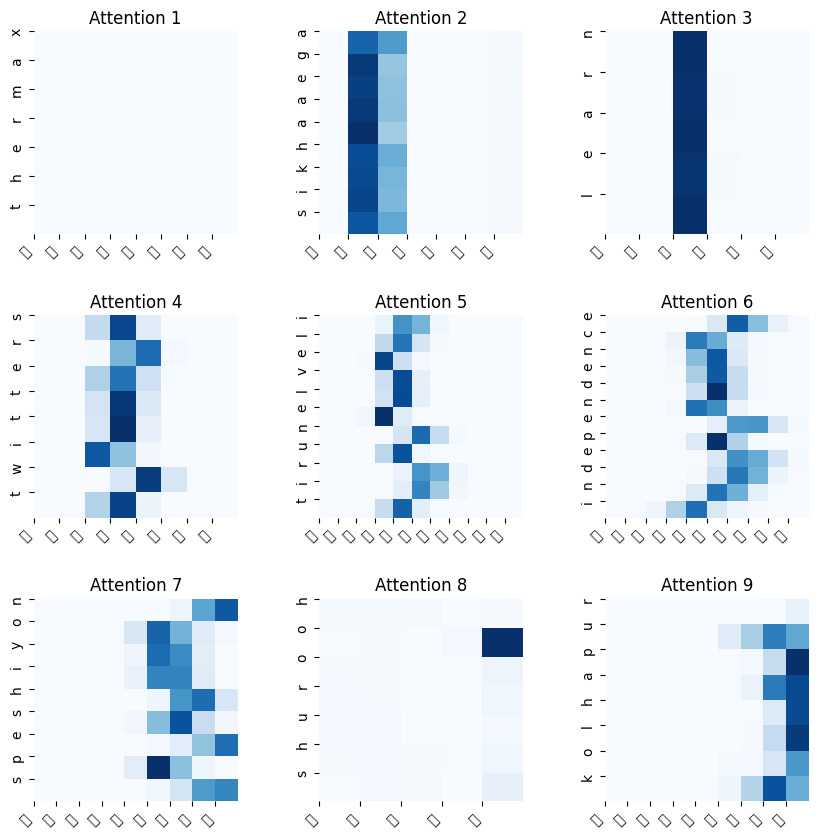

test_accuracy,▃▅▅▆▅▃▆▃▃▂▂▇▂▆▁▅▅▄▇▇▆▄▄▅▄▃▆▄▅▅▄▄▇▅▆▄▇▅▅█
test_loss,▆▁▂▂▂▅▁▇▃▂▃▂▅▃▅▃▄▄▂▂▂▅█▃▂▂▂▄▂▁▂▃▂▄▂▄▂▂▂▃
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▅▆▇█████
val_loss,█▃▂▂▁▁▁▁▂▁
test_accuracy,53.125
test_loss,0.42325
train_accuracy,55.45703
train_loss,0.14424
val_accuracy,41.38184


In [17]:
wandb.init()
# Create a Trainer for training the model
trainer = pl.Trainer(max_epochs=epochs, accelerator="gpu", devices=1)
# Set the run name in WandB
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
# Evaluate the trained model on the test dataset
trainer.test(model, test_dataloader)
wandb.finish()

In [18]:
# import csv
# rows = []
# count=0
# with open("/kaggle/working/Output.csv", 'r') as file:
#     csvreader = csv.reader(file)
#     header = next(csvreader)
#     for row in csvreader:
#         rows.append(row)
#         count=count+1
#         if(count==15):
#             break
# print(header)
# print(rows)

['input', 'target', 'predicted']
[['thermax', 'थरमैक्स', 'थर्माक्स'], ['sikhaaega', 'सिखाएगा', 'सिखाएगा'], ['learn', 'लर्न', 'लीयर्न'], ['twitters', 'ट्विटर्स', 'ट्विटर्स'], ['tirunelveli', 'तिरुनेलवेली', 'तिरुनेलवेली'], ['independence', 'इंडिपेंडेंस', 'इंडपेंडेंस'], ['speshiyon', 'स्पेशियों', 'स्पेशियों'], ['shurooh', 'शुरूः', 'शुरूह'], ['kolhapur', 'कोल्हापुर', 'कोल्हापुर'], ['ajhar', 'अजहर', 'अझर'], ['karaar', 'क़रार', 'करार'], ['anka', 'अंक', 'अंका'], ['wpd', 'डब्ल्यूपीडी', 'वीपीडी'], ['haashie', 'हाशिए', 'हाशी'], ['glendale', 'ग्लेंडल', 'ग्लेंडाल']]
